In [41]:
import pickle
from __future__ import division

# Python 2 & 3 Compatibility
from __future__ import print_function, division
from sklearn import linear_model,ensemble, tree, model_selection, datasets

# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline
from sklearn import preprocessing as pp

import pandas as pd
import numpy as np
import seaborn as sns
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import scipy.stats as stats


In [42]:
# Get the dataset from the pickle

with open("kickstarter_data_pickle.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)
df = df.reset_index(drop=True)

In [43]:
# create the response variable (y) which will be the % relationship to 'on-track' toward the campaign goal.  i.e. a campaign that is 40% through its allowed time should be 40% of the way toward its $ goal.  If the campaign is at 30% of its $ goal then it is at 30/40 = 
df['total_days'] = df['days_remaining']
df.loc[df['total_days'] > 29, 'total_days'] = 60
df.loc[df['total_days'] < 30, 'total_days'] = 30
# technically this is an assumption.  It is nearly universal to run a campaign for 30 days, (the default) or 60 days (the max) but I was unable to scrape the campaign start date so I cannot be sure of the exact total length.  There will definitely be some error introduced here.  

df['percent_complete_time'] = (df['total_days'] - df['days_remaining'])/df['total_days'] # How far through the campaign are they (a score of 1 means they're done).
df['current_target_funds'] = df['total_goal']*df['percent_complete_time']
df['y'] = df['raised_so_far']/df['current_target_funds'] # the percent of the current target funds which have been raised.  
df


,title,URL,total_goal,raised_so_far,backers_count,days_remaining,number_images,contains_video,tier_count,updates_total,title_length,category,sub_category,all_or_nothing,total_text,total_days,percent_complete_time,current_target_funds,y
0,FILM PIONEER GEORGES MÉLIÈS'S LONG-LOST AUTOBI...,www.kickstarter.com/projects/832232974/film-pi...,15380,53173,584,2,18,True,2,5,53,[Publishing],Nonfiction,True,8529,30,0.933333,14354.7,3.70423
1,Socialism: An American Story,www.kickstarter.com/projects/socialismmovie/so...,100000,14296,216,29,6,True,16,0,28,[Film_And_Video],Documentary,True,8135,30,0.0333333,3333.33,4.2888
2,Faeland,www.kickstarter.com/projects/1551918612/faeland,29000,32776,1268,21,42,True,21,6,7,[Games],Video Games,True,17715,30,0.3,8700,3.76736
3,Nita Strauss Debut Solo Album!,www.kickstarter.com/projects/hurricanenita/nit...,20000,111759,1201,8,8,True,22,2,30,[Music],Rock,True,12693,30,0.733333,14666.7,7.61993
4,Reissuing Isaac Newton’s Opticks,www.kickstarter.com/projects/1174653512/reissu...,42781,43013,557,42,22,True,6,1,32,[Publishing],Publishing,True,7510,60,0.3,12834.3,3.35141
5,Savage Impressions: The Book,www.kickstarter.com/projects/p22/savage-impres...,40000,6617,72,25,8,True,23,0,28,[Publishing],Art Books,True,13596,30,0.166667,6666.67,0.99255
6,"The Eyeslicer's Bigger, Weirder, Darker SEASON...",www.kickstarter.com/projects/597323965/the-eye...,32000,4601,107,29,13,True,15,1,50,[],Film & Video,True,14881,30,0.0333333,1066.67,4.31344
7,Human Food - Vegan & Organic Meal Replacement Bar,www.kickstarter.com/projects/1313545942/human-...,111856,108477,761,2,11,True,8,7,49,[Food],Vegan,True,15129,30,0.933333,104399,1.03906
8,Hippopotomonstrosesquipedalian - Big Words for...,www.kickstarter.com/projects/864723063/hippopo...,10000,10410,196,20,11,True,11,4,58,[Publishing],Children's Books,True,6074,30,0.333333,3333.33,3.123
9,Vite Ramen: The Nutritionally Complete Instant...,www.kickstarter.com/projects/1923918237/vite-r...,10000,83427,1312,23,40,True,19,3,53,[Food],Food,True,13256,30,0.233333,2333.33,35.7544


In [44]:
# change a couple of data types and scale a few things
df['updates_scaled'] = df['updates_total']*df['total_days']/(df['total_days'] - df['days_remaining']) # we scale the updates based on the assumption that campaigns will continue posting as often as they have done.  
df['backers_scaled'] = df['backers_count']*df['total_days']/(df['total_days'] - df['days_remaining']) # we scale the backers based on the assumption that campaigns will accruing backers as often as they have done.  
df.all_or_nothing.unique() #shows that ALL camnpaigns were 'all or nothing' type so we will not be including that variable.  

df[['total_goal','backers_count','days_remaining','number_images','contains_video','tier_count','title_length','all_or_nothing','total_text','total_days']] = df[['total_goal','backers_count','days_remaining','number_images','contains_video','tier_count','title_length','all_or_nothing','total_text','total_days']].astype(int)
df[['updates_scaled']] = df[['updates_scaled']].astype(float)
df[['backers_scaled']] = df[['backers_scaled']].astype(float)

df['total_days_binary'] = df['total_days']
df.loc[df['total_days_binary'] == 30, 'total_days_binary'] = 1
df.loc[df['total_days_binary'] == 60, 'total_days_binary'] = 0


In [45]:
#here's the matrix of variables we care about: 

dfx = df[['total_goal','backers_scaled','number_images','contains_video','tier_count','updates_scaled','title_length','total_text','total_days','y']].copy()
dfx = dfx[dfx.y < 5]

# We also can't take the log of 0 for those campaigns that have raised nothing so far 
#dfx['y'] = dfx['y']+.001   # so we could simply give them 1 cent
dfx = dfx[dfx.y != 0] # or we could remove them from the dataset.  

dfx.corr()
#dfx.info()


,total_goal,backers_scaled,number_images,contains_video,tier_count,updates_scaled,title_length,total_text,total_days
total_goal,1.000000,0.262742,0.097397,0.063295,0.035208,0.001725,-0.007649,0.153234,0.050043
backers_scaled,0.262742,1.000000,0.263059,0.110473,0.137613,0.228440,0.005444,0.222911,-0.053239
number_images,0.097397,0.263059,1.000000,0.173836,0.297501,0.209192,0.130526,0.445501,-0.030529
contains_video,0.063295,0.110473,0.173836,1.000000,0.150150,0.129097,0.047185,0.193876,-0.017285
tier_count,0.035208,0.137613,0.297501,0.150150,1.000000,0.180116,0.064274,0.560014,-0.052054
updates_scaled,0.001725,0.228440,0.209192,0.129097,0.180116,1.000000,0.070169,0.223417,-0.070860
title_length,-0.007649,0.005444,0.130526,0.047185,0.064274,0.070169,1.000000,0.153803,-0.006166
total_text,0.153234,0.222911,0.445501,0.193876,0.560014,0.223417,0.153803,1.000000,-0.015411
total_days,0.050043,-0.053239,-0.030529,-0.017285,-0.052054,-0.070860,-0.006166,-0.015411,1.000000


In [46]:
X = dfx.drop(['y'], axis=1)  
X = sm.add_constant(X)
y = list(dfx.y)

# Split the dataset into parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [47]:
models = {}
parameters = {}

models['linear_model'] = linear_model.LinearRegression()
models['ridge_model'] = linear_model.Ridge()
models['lasso_model'] = linear_model.Lasso(alpha=.5)
models['robust_regression'] = linear_model.SGDRegressor(loss='huber',max_iter=2000)
models['eps_insensitive'] = linear_model.SGDRegressor(loss='epsilon_insensitive',max_iter=2000)


models['cart'] = tree.DecisionTreeRegressor(max_depth=7)
models['extratrees'] = tree.ExtraTreeRegressor(max_depth=7)
models['randomForest'] = ensemble.RandomForestRegressor()
models['adaboostedTrees'] = ensemble.AdaBoostRegressor()
models['gradboostedTrees'] = ensemble.GradientBoostingRegressor()


for name,model in models.items():
    scores = model_selection.cross_val_score(model, X_train, y_train, n_jobs=1)
    print('Model: '+name)
    print("Score: " + str(np.mean(scores)))
    print()

Model: linear_model
Score: 0.19277736923846692

Model: ridge_model
Score: 0.19279189585659198

Model: lasso_model
Score: 0.18632012658295016

Model: robust_regression
Score: -41091561010.57408

Model: eps_insensitive
Score: -10141198485602.61

Model: cart
Score: 0.4552738124706642

Model: extratrees
Score: 0.26489535441598955

Model: randomForest
Score: 0.6059347967036234

Model: adaboostedTrees
Score: 0.5178446321634231

Model: gradboostedTrees
Score: 0.6393721766766337



In [48]:
coefs = models['gradboostedTrees'].fit(X,y).feature_importances_
sorted(zip(X.columns,coefs), key = lambda x:x[1], reverse=True)


[('backers_scaled', 0.33155746466418085),
 ('total_goal', 0.28441256234643664),
 ('number_images', 0.11296007284577066),
 ('total_text', 0.09108150529353772),
 ('updates_scaled', 0.07342932708827818),
 ('tier_count', 0.04838669250755375),
 ('title_length', 0.04302816621527333),
 ('total_days', 0.012979938540404497),
 ('contains_video', 0.0021642704985642552),
 ('const', 0.0)]

In [49]:
# Select for the strongest variables:
X_reduced = X_train[['backers_scaled','total_goal','total_days','number_images','updates_scaled']]

for name,model in models.items():
    scores = model_selection.cross_val_score(model, X_reduced, y_train, n_jobs=-1)
    print('Model: '+name)
    print("Score: " + str(np.mean(scores)))
    print()

Model: linear_model
Score: 0.18925060462523702

Model: ridge_model
Score: 0.18925228882916498

Model: lasso_model
Score: 0.18639058416631296

Model: robust_regression
Score: -162401013384.7782

Model: eps_insensitive
Score: -16265775532685.037

Model: cart
Score: 0.5155143531194547

Model: extratrees
Score: 0.32046993693081877

Model: randomForest
Score: 0.5999353474367862

Model: adaboostedTrees
Score: 0.5214593453666047

Model: gradboostedTrees
Score: 0.6413108459670545



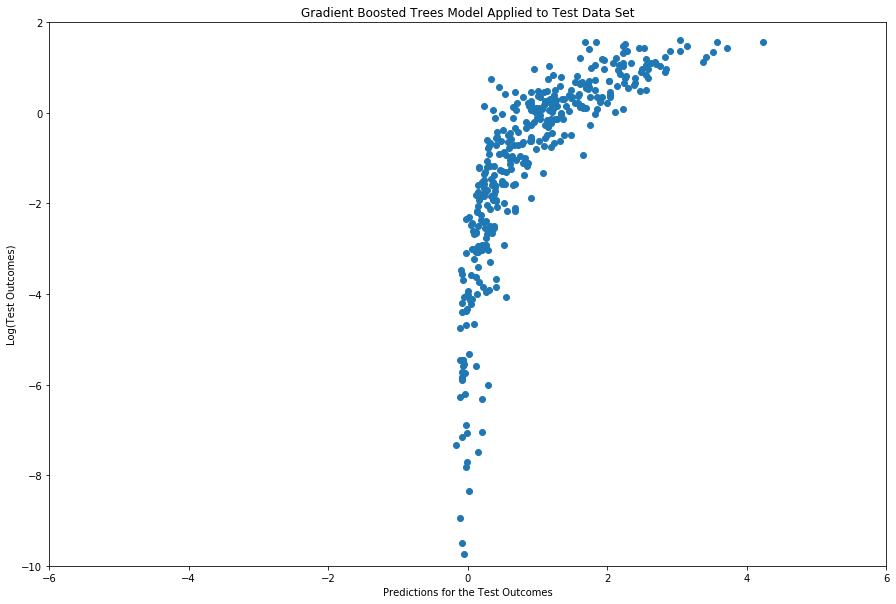

In [50]:
# plot predictions from the X_test set against log(y_test)
plt.figure(figsize=(15,10));
predictions1 = models['gradboostedTrees'].predict(X_test)
plt.scatter(predictions1,np.log(y_test))
plt.ylabel("Log(Test Outcomes)")
plt.xlabel('Predictions for the Test Outcomes')
plt.title('Gradient Boosted Trees Model Applied to Test Data Set')
plt.axis([-6, 6, -10, 2]);

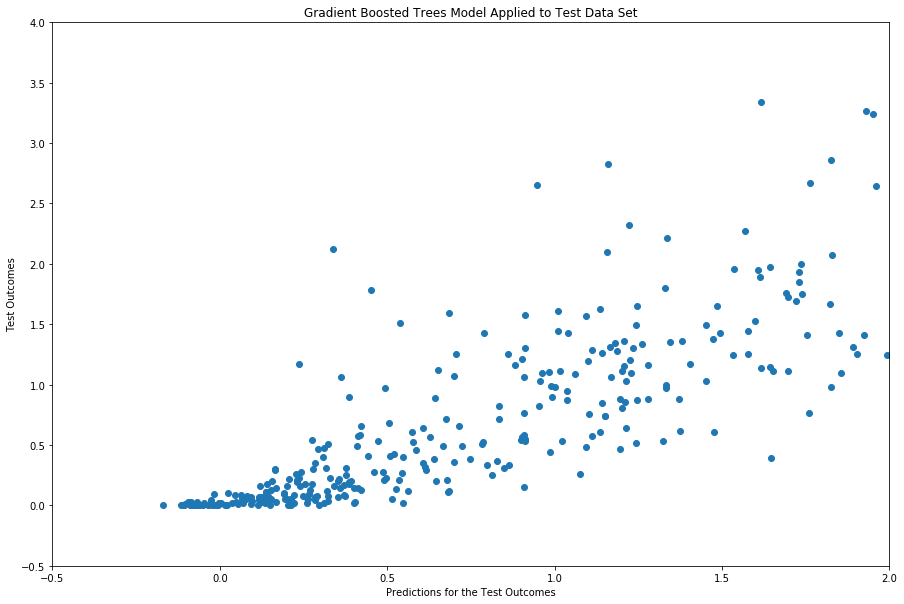

In [51]:
# plot predictions from the X_test set against y_test
plt.figure(figsize=(15,10));
predictions1 = models['gradboostedTrees'].predict(X_test)
plt.scatter(predictions1,y_test)
plt.ylabel("Test Outcomes")
plt.xlabel('Predictions for the Test Outcomes')
plt.title('Gradient Boosted Trees Model Applied to Test Data Set')
plt.axis([-.5, 2, -.5, 4]);

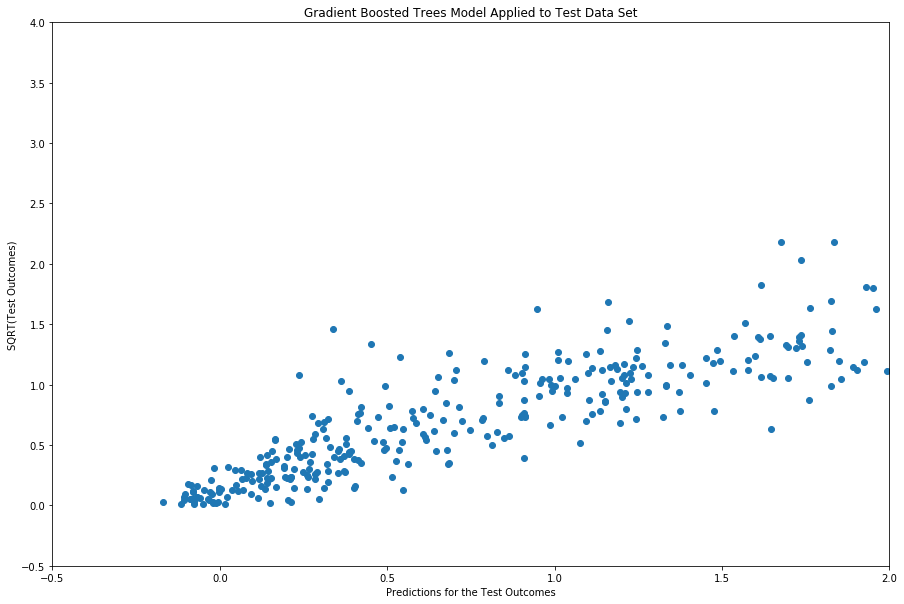

In [52]:
# plot predictions from the X_test set against sqareroot y_test
plt.figure(figsize=(15,10));
predictions1 = models['gradboostedTrees'].predict(X_test)
plt.scatter(predictions1,np.sqrt(y_test))
plt.ylabel("SQRT(Test Outcomes)")
plt.xlabel('Predictions for the Test Outcomes')
plt.title('Gradient Boosted Trees Model Applied to Test Data Set')
plt.axis([-.5, 2, -.5, 4]);

In [53]:
# How good is our model on the test set?

# Root Mean Square Error
print('Root Mean Square Error = SD: ')
print(np.sqrt(np.mean((predictions1 - y_test)**2)))
print()
# Mean Absolute Deviation
print('Variance')
print((np.mean(np.abs(predictions1 - y_test))))
print()

# Adjusted by sqrt for our particular model
print('Adjusted RMSE')
print(np.sqrt(np.sqrt(np.mean((predictions1 - y_test)**2))))
# Whereas R-squared is a relative measure of fit, RMSE is an absolute measure of fit. 
# As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance, 
# and has the useful property of being in the same units as the response variable. Lower values of RMSE indicate 
# better fit.

Root Mean Square Error = SD: 
0.5635209685155975

Variance
0.35402686637000585

Adjusted RMSE
0.750680337104681
